In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sfdmap

m = sfdmap.SFDMap('../../DATA/sfddata-master/')

m.ebv(0,0)

0.027364157827046952

In [3]:
NB_BINS = 360
ZMIN = 0.0
ZMAX = 1.0
BIN_SIZE = (ZMAX - ZMIN) / NB_BINS
range_z = np.linspace(ZMIN, ZMAX, NB_BINS + 1)[:NB_BINS]

In [4]:
use_columns = ['ZBEST','gFKronFlux', 'rFKronFlux', 'iFKronFlux', 'zFKronFlux',
       'yFKronFlux', 'gFPSFFlux', 'rFPSFFlux', 'iFPSFFlux',
       'zFPSFFlux', 'yFPSFFlux', 'gFApFlux', 'rFApFlux', 'iFApFlux',
       'zFApFlux', 'yFApFlux','gFmeanflxR5', 'rFmeanflxR5', 'iFmeanflxR5',
       'zFmeanflxR5', 'yFmeanflxR5','gFmeanflxR6',
       'rFmeanflxR6', 'iFmeanflxR6', 'zFmeanflxR6', 'yFmeanflxR6',
       'gFmeanflxR7', 'rFmeanflxR7', 'iFmeanflxR7',
       'zFmeanflxR7', 'yFmeanflxR7','raMean','decMean']

X_COLUMNS = ['gFKronFlux', 'rFKronFlux', 'iFKronFlux', 'zFKronFlux',
       'yFKronFlux', 'gFPSFFlux', 'rFPSFFlux', 'iFPSFFlux',
       'zFPSFFlux', 'yFPSFFlux', 'gFApFlux', 'rFApFlux', 'iFApFlux',
       'zFApFlux', 'yFApFlux','gFmeanflxR5', 'rFmeanflxR5', 'iFmeanflxR5',
       'zFmeanflxR5', 'yFmeanflxR5','gFmeanflxR6',
       'rFmeanflxR6', 'iFmeanflxR6', 'zFmeanflxR6', 'yFmeanflxR6',
       'gFmeanflxR7', 'rFmeanflxR7', 'iFmeanflxR7',
       'zFmeanflxR7', 'yFmeanflxR7']

In [5]:
DF = pd.read_csv('./../../DATA/new_MAST_RETURNED_DF/no_repeats/no_repeats.csv',usecols=use_columns)

In [6]:
RA = DF['raMean'].values
DEC = DF['decMean'].values

In [7]:
EXTINCTIONS = m.ebv(RA,DEC)

In [8]:
Y = DF['ZBEST'].values
X = DF[X_COLUMNS].values

In [9]:
X = np.concatenate((X,EXTINCTIONS[:,None]),axis=1)
np.shape(X)

(933152, 31)

In [10]:
#Pair down to Y < 1
X = X[Y<ZMAX]
Y = Y[Y<ZMAX]

X = X[Y>=ZMIN]
Y = Y[Y>=ZMIN]

# Next we need to convert fluxes to luptitudes (allows us to deal with negative flux)

In [11]:
#m = -2.5/ln(10) * [asinh((f/f0)/(2b)) + ln(b)]

#The asinh magnitudes are characterized by a softening parameter b, the typical 1-sigma 
#noise of the sky in a PSF aperture in 1'' seeing. The relation between detected flux f and asinh magnitude m is:

f_0 = 3631 #Jy

#https://iopscience.iop.org/article/10.1088/0004-637X/756/2/158/pdf table1

#1 square arcsecond sky background magnitude, use it to find b
g_mu = 21.92
r_mu = 20.83
i_mu = 19.79
z_mu = 19.24
y_mu = 18.24

b_g = np.exp((g_mu*np.log(10)/-2.5) - np.arcsinh((1/(2*f_0))))
b_r = np.exp((r_mu*np.log(10)/-2.5) - np.arcsinh((1/(2*f_0))))
b_i = np.exp((i_mu*np.log(10)/-2.5) - np.arcsinh((1/(2*f_0))))
b_z = np.exp((z_mu*np.log(10)/-2.5) - np.arcsinh((1/(2*f_0))))
b_y = np.exp((y_mu*np.log(10)/-2.5) - np.arcsinh((1/(2*f_0))))

def convert_flux_to_luptitude(f,b,f_0=3631):
    return -2.5/np.log(10) * (np.arcsinh((f/f_0)/(2*b)) + np.log(b))

In [12]:
#g
X[:,[0,5,10,15,20,25]] = convert_flux_to_luptitude(X[:,[0,5,10,15,20,25]],b=b_g)

#r
X[:,[1,6,11,16,21,26]] = convert_flux_to_luptitude(X[:,[1,6,11,16,21,26]],b=b_r)

#i
X[:,[2,7,12,17,22,27]] = convert_flux_to_luptitude(X[:,[2,7,12,17,22,27]],b=b_i)

#z
X[:,[3,8,13,18,23,28]] = convert_flux_to_luptitude(X[:,[3,8,13,18,23,28]],b=b_z)

#y
X[:,[4,9,14,19,24,29]] = convert_flux_to_luptitude(X[:,[4,9,14,19,24,29]],b=b_y)

In [13]:
#Robust to outliers

MEANS = np.median(X,axis=0)
IQR = np.quantile(X,axis=0,q=[0.75,0.25])
STDS = (IQR[0,] - IQR[1,]) / 1.34896


X = (X - MEANS)/STDS

#robust to missing data
X[np.isnan(X)] = -20
#Fix outliers
X[X<-20] = -20
X[X>20] = 20

print(np.shape(X))

(932381, 31)


In [14]:
MEANS

array([18.70654578, 17.77948707, 17.34226094, 17.1227873 , 16.92087669,
       19.73947441, 18.89279411, 18.4077393 , 18.1311733 , 17.64741402,
       19.01595669, 18.16447837, 17.73199409, 17.50486095, 17.20389615,
       19.07834251, 18.16996592, 17.71492073, 17.44861273, 17.15508793,
       18.79100201, 17.89569908, 17.45774026, 17.20338482, 16.93640741,
       18.62759241, 17.7453392 , 17.31341498, 17.06194499, 16.79030564,
        0.02543223])

In [15]:
STDS

array([1.7657395 , 1.24853534, 1.08151972, 1.03490545, 0.87252421,
       1.32486758, 0.9222839 , 0.73701807, 0.65002723, 0.41779001,
       1.51554956, 1.05734494, 0.89939638, 0.82754093, 0.63381611,
       1.48411417, 1.05425943, 0.89979008, 0.83934385, 0.64990996,
       1.54735158, 1.10985163, 0.96460099, 0.90685922, 0.74507053,
       1.57813401, 1.14290345, 1.00162105, 0.94634726, 0.80124359,
       0.01687839])

# Class

In [16]:
#Make into classes
Y_classes = np.round(Y * NB_BINS,0).astype(np.int32) #0-360, need to correct rounding up to 359
Y_classes[Y_classes>=NB_BINS] = NB_BINS-1

# Test train split

In [19]:
indices = np.arange(len(X))
SEED=0
random.seed(SEED)

random.shuffle(indices)

train_indices = indices[int(0*len(indices)):int(0.8*len(indices))]
test_indices = indices[int(0.8*len(indices)):int(0.9*len(indices))]
val_indices = indices[int(0.9*len(indices)):int(1.0*len(indices))]


X_train = X[train_indices]
Y_train = Y_classes[train_indices]

X_test = X[test_indices]
Y_test = Y_classes[test_indices]

Y_test_real = Y[test_indices]

X_val = X[val_indices]
Y_val = Y_classes[val_indices]

# Model

In [20]:
def model():
    INPUT = tf.keras.layers.Input(31)
    
    DENSE1 = tf.keras.layers.Dense(256,activation=tf.keras.layers.LeakyReLU(),kernel_initializer=tf.keras.initializers.he_normal(),kernel_regularizer=tf.keras.regularizers.l2(1e-5))(INPUT)
    DROP1 = tf.keras.layers.Dropout(0.05)(DENSE1)
    
    DENSE2 = tf.keras.layers.Dense(1024,activation=tf.keras.layers.LeakyReLU(),kernel_initializer=tf.keras.initializers.he_normal(),kernel_regularizer=tf.keras.regularizers.l2(1e-5))(DROP1)
    DROP2 = tf.keras.layers.Dropout(0.05)(DENSE2)
    
    DENSE3 = tf.keras.layers.Dense(1024,activation=tf.keras.layers.LeakyReLU(),kernel_initializer=tf.keras.initializers.he_normal(),kernel_regularizer=tf.keras.regularizers.l2(1e-5))(DROP2)
    DROP3 = tf.keras.layers.Dropout(0.05)(DENSE3)
    
    DENSE4 = tf.keras.layers.Dense(1024,activation=tf.keras.layers.LeakyReLU(),kernel_initializer=tf.keras.initializers.he_normal(),kernel_regularizer=tf.keras.regularizers.l2(1e-5))(DROP3)
    
    OUTPUT = tf.keras.layers.Dense(360,activation=tf.keras.activations.softmax)(DENSE4)
    
    model = tf.keras.Model(INPUT,OUTPUT)
    
    return model

In [21]:
tf.keras.backend.clear_session()

mymodel = model()

filepath='./MLP_luptons_class_3-21-21.hdf5'
CB = tf.keras.callbacks.ModelCheckpoint(filepath,verbose=1)

mymodel.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-4))

In [23]:
if True:
    hist = mymodel.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=128,epochs=40,callbacks=[CB])

Epoch 1/50
5828/5828 [==============================] - 27s 4ms/step - loss: 4.4510 - val_loss: 3.8324

Epoch 00001: saving model to .\MLP_luptons_class_3-21-21.hdf5
Epoch 2/50
5828/5828 [==============================] - 26s 5ms/step - loss: 3.8365 - val_loss: 3.7281

Epoch 00002: saving model to .\MLP_luptons_class_3-21-21.hdf5
Epoch 3/50
5828/5828 [==============================] - 27s 5ms/step - loss: 3.7377 - val_loss: 3.6690

Epoch 00003: saving model to .\MLP_luptons_class_3-21-21.hdf5
Epoch 4/50
5828/5828 [==============================] - 27s 5ms/step - loss: 3.6887 - val_loss: 3.6439

Epoch 00004: saving model to .\MLP_luptons_class_3-21-21.hdf5
Epoch 5/50
5828/5828 [==============================] - 27s 5ms/step - loss: 3.6572 - val_loss: 3.6214

Epoch 00005: saving model to .\MLP_luptons_class_3-21-21.hdf5
Epoch 6/50
5828/5828 [==============================] - 27s 5ms/step - loss: 3.6348 - val_loss: 3.6115

Epoch 00006: saving model to .\MLP_luptons_class_3-21-21.hdf5
Epoc

5828/5828 [==============================] - 27s 5ms/step - loss: 3.4231 - val_loss: 3.4785

Epoch 00050: saving model to .\MLP_luptons_class_3-21-21.hdf5


In [24]:
mymodel.load_weights(filepath)

In [25]:
OUT = mymodel(X_test,training=False).numpy()

In [26]:
TEST_OUT = np.sum(OUT*range_z,axis=1)

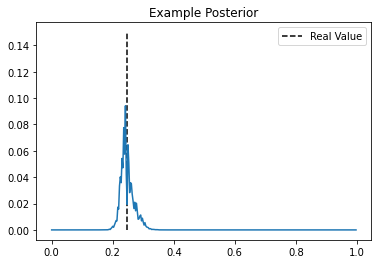

In [27]:
index=15

plt.title('Example Posterior')
plt.plot(range_z,OUT[index,:])
plt.vlines(TEST_OUT[index],0,0.15,color='k',linestyle='dashed',label='Real Value')
plt.legend()

plt.show()

In [28]:
residuals_scaled = (TEST_OUT - Y_test_real)/(1+Y_test_real)

In [29]:
#Using Pasquet's definition

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=5*MAD)/len(residuals_scaled)

print('Pasquets Defintions: ')
print('MAD: ',np.round(MAD,4))
print('BIAS: ',np.round(BIAS,4))
print('ETA: ',np.round(100*ETA,4),'% 5 sigma_mad, percentage')
print(' ')
print('Becks Defintions')
print('O: ',np.round(100*np.sum(abs(residuals_scaled)>0.15)/len(residuals_scaled),4),'%')
print('MAD: ',np.round(1.4826*np.median(abs(residuals_scaled[abs(residuals_scaled)<=0.15] - np.median(residuals_scaled[abs(residuals_scaled)<=0.15]))),4))
print('STD: ',np.round(np.std(residuals_scaled[abs(residuals_scaled)<=0.15]),4))
print('BIAS: ',np.round(np.mean(residuals_scaled[abs(residuals_scaled)<=0.15]),4))
#Tarrio et al 2020 using multiple local linear regression
#BIAS = -2e-4 (after remove 3 sigma outliers)
#STD = 0.0298 
#ETA = 
print(' ')
print('Tarrio Defintions')
print('STD: ',np.round(np.std(residuals_scaled),4))
print('BIAS: ',np.round(np.mean(residuals_scaled[abs(residuals_scaled)<=3*np.std(residuals_scaled)]),4))
print('P0: ','Actually they dont well define this metric')
print(' ')
print(' ')
print(' ')
print('Tarrio 2020s STD: 0.0298')
print('Tarrio 2020s BIAS: -2.01e-4')
#Beck 2020
print(' ')
print('Beck 2019s O: 1.89%')
print('Beck 2019s MAD: 0.0161')
print('Beck 2019s STD: 0.0322')
print('Beck 2019s BIAS: 5e-4')

Pasquets Defintions: 
MAD:  0.0155
BIAS:  0.002
ETA:  1.1519 % 5 sigma_mad, percentage
 
Becks Defintions
O:  0.3057 %
MAD:  0.0155
STD:  0.0212
BIAS:  0.0018
 
Tarrio Defintions
STD:  0.0257
BIAS:  0.0018
P0:  Actually they dont well define this metric
 
 
 
Tarrio 2020s STD: 0.0298
Tarrio 2020s BIAS: -2.01e-4
 
Beck 2019s O: 1.89%
Beck 2019s MAD: 0.0161
Beck 2019s STD: 0.0322
Beck 2019s BIAS: 5e-4


In [34]:
def PIT(X,Out,title='title',string='plot.png',save=False,n_classes=180):
    """
    X = spectro Z array
    Out = probabilities array
    """
    #print(np.shape(X))
    X_true_bin = np.round((X/ZMAX)*(n_classes-1),0).astype(int)
    X_true_bin[X_true_bin>=n_classes] = n_classes-1 
    PIT = []

    #print(np.shape(X_true_bin))
    #print(np.shape(Out))
    for i in range(len(X_true_bin)):
        PIT.append(np.sum((Out[i,:])[0:X_true_bin[i]]))

    PIT=np.asarray(PIT)

    n_bins=n_classes
    bins=np.linspace(0,1,n_bins)
    #draw the line that is if it was a perfect distribution. it would have..
    #len(PIT)/180 #number in each bin
    plt.hlines((len(PIT)/n_bins),0,1,colors='k',linestyles='solid')
    plt.xlim(0,1)
    plt.hist(PIT,bins)
    plt.title(title)
    if save==True:
        plt.savefig(string)
    plt.show()

    #catastropic outliers are thos with PIT values <0.0001 or >0.9999; a normal distribution would have 0.0002 fraction
    catastropic_outlier_fraction = (len(PIT[PIT<0.0001]) + len(PIT[PIT>0.9999])) / len(PIT)
    print(catastropic_outlier_fraction)
    print(' ')
    print("Normal distribution's fraction is 0.0002") 

In [35]:
Y_pred = mymodel(X_test,training=False).numpy()

In [ ]:
from scipy.stats import kde
x = Y_test_real
y = np.sum(range_z*Y_pred,1) #for categorical


#CRPS, FOR CLASS ONLY:
z_bins = Y_test
CRPS=np.zeros(len(Y_test))
for i in range(len(CRPS)):
    CRPS[i] = (np.sum((np.cumsum(Y_pred[i,0:z_bins[i]]))**2) + np.sum((np.cumsum(Y_pred[i,z_bins[i]::])-1)**2)) * BIN_SIZE
CRPS_estimator=np.mean(CRPS)
print('CRPS estimator: ',CRPS_estimator)
#summary stats

#KDE plot
nbins=300
x=x[::25]
y=y[::25]

k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[0:ZMAX:nbins*1j, 0:ZMAX:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='plasma')
plt.plot([0,1],[0,1],'k--')
plt.xlim(0,0.6)
plt.ylim(0,0.6)
plt.title('MLP: every 25th point')
plt.colorbar()
plt.show()

PIT(Y_test/NB_BINS,Y_pred,'MLP PIT',n_classes=NB_BINS)